# KNN with Dataset Adult

Felipe Kenzo Kusakawa Mashuda - 10274415

*Eu não sei o que estou fazendo* :)

---

**Bibliotecas:**

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sklearn

## 1. Importação de Dados

Vamos começar importando os dados de treino do *dataset*.

In [2]:
training = pd.read_csv("train_data.csv", na_values="?")
training.head()

,Id,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,16280,34,Private,204991,Some-college,10,Divorced,Exec-managerial,Own-child,White,Male,0,0,44,United-States,<=50K
1,16281,58,Local-gov,310085,10th,6,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,<=50K
2,16282,25,Private,146117,Some-college,10,Never-married,Machine-op-inspct,Not-in-family,White,Male,0,0,42,United-States,<=50K
3,16283,24,Private,138938,Some-college,10,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,<=50K
4,16284,57,Self-emp-inc,258883,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,5178,0,60,Hungary,>50K


## 2. Limpeza e Manipulação de Dados

Já começamos a ver a carinha do *dataset*. No entanto, fica evidente que é necessário dar uma "polida" nos nossos dados. Vamos começar removendo a coluna "Id", que não é um atributo.

In [3]:
del training['Id']
training.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,34,Private,204991,Some-college,10,Divorced,Exec-managerial,Own-child,White,Male,0,0,44,United-States,<=50K
1,58,Local-gov,310085,10th,6,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,<=50K
2,25,Private,146117,Some-college,10,Never-married,Machine-op-inspct,Not-in-family,White,Male,0,0,42,United-States,<=50K
3,24,Private,138938,Some-college,10,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,<=50K
4,57,Self-emp-inc,258883,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,5178,0,60,Hungary,>50K


Também é interessante modificar o nome de algumas colunas que possuem '.';\.

In [4]:
training = training.rename(columns = {'education.num':'education-num',
                          'marital.status':'marital-status',
                          'capital.gain':'capital-gain',
                          'capital.loss':'capital-loss',
                          'hours.per.week':'hours-per-week',
                          'native.country':'native-country'})

Em seguida, vamos utilizar o método `.info()` para investigar os tipos e as quantidades de cada *feature*.

In [5]:
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32560 entries, 0 to 32559
Data columns (total 15 columns):
age               32560 non-null int64
workclass         30724 non-null object
fnlwgt            32560 non-null int64
education         32560 non-null object
education-num     32560 non-null int64
marital-status    32560 non-null object
occupation        30717 non-null object
relationship      32560 non-null object
race              32560 non-null object
sex               32560 non-null object
capital-gain      32560 non-null int64
capital-loss      32560 non-null int64
hours-per-week    32560 non-null int64
native-country    31977 non-null object
income            32560 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


Opa, temos dados faltantes! Por simplicidade, irei utilizar a moda para imputar esses valores.

In [6]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imputer.fit_transform(training)
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32560 entries, 0 to 32559
Data columns (total 15 columns):
age               32560 non-null int64
workclass         30724 non-null object
fnlwgt            32560 non-null int64
education         32560 non-null object
education-num     32560 non-null int64
marital-status    32560 non-null object
occupation        30717 non-null object
relationship      32560 non-null object
race              32560 non-null object
sex               32560 non-null object
capital-gain      32560 non-null int64
capital-loss      32560 non-null int64
hours-per-week    32560 non-null int64
native-country    31977 non-null object
income            32560 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


Pronto! Agora podemos usar todos os exemplos.

## 3. Análise de Dados Exploratória

### 3.1. workclass

A classe trabalhadora, por intuição, parece ser um bom indicativo da renda de uma pessoa. Vamos dar uma olhada em como esse atributo está distribuído:

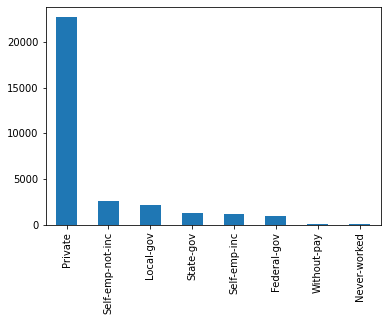

In [7]:
training['workclass'].value_counts().plot(kind="bar");

A grande maioria das pessoas trabalha no setor privado. Uma visualização interessante poderia ser a 
quantidade relativa de pessoas que ganham mais de 50k em cada categoria.

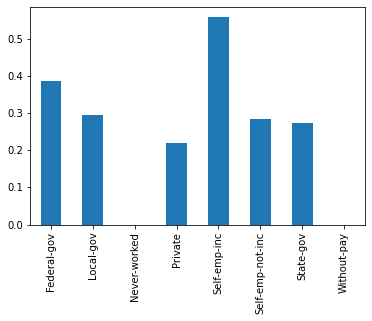

In [8]:
(training.loc[training['income']=='>50K']['workclass'].value_counts()/training['workclass'].value_counts()).plot(kind='bar')

Aparentemente, em quase todas as classes há uma minoria de pessoas que ganham acima de 50k por ano. A única diferença foi nos 'self-emp-inc', que ultrapassou 50%.

### 3.2. fnlwgt

Essa *feature* representa a quantidade de pessoas que um exemplo representaria da população estadounidense. Não sei se seria muito útil para o KNN. De qualquer forma, comecemos analisando a sua distribuição.

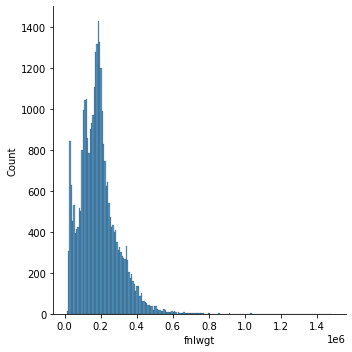

In [9]:
sns.displot(training['fnlwgt'])

### 3.3. education e education-num

Essas duas *features* aparentam serem redundantes. Vamos ver se é o caso:

In [10]:
training['education'].unique()

array(['Some-college', '10th', 'HS-grad', 'Bachelors', 'Assoc-acdm',
       '5th-6th', 'Masters', '12th', 'Prof-school', 'Doctorate', '9th',
       '1st-4th', '7th-8th', 'Assoc-voc', '11th', 'Preschool'],
      dtype=object)

In [11]:
training['education'].describe()

count       32560
unique         16
top       HS-grad
freq        10501
Name: education, dtype: object

Primeiro, vemos que há 16 graus de educação diferentes. Dentre eles, o nível de ensino médio é o mais frequente.

In [12]:
training['education-num'].unique()

array([10,  6,  9, 13, 12,  3, 14,  8, 15, 16,  5,  2,  4, 11,  7,  1])

Novamente, temos 16 diferentes valores. Se cada número correspondesse a um nível de educação, então a primeira seria "Preschool", seguida de "1st-4th", "5th-6th", até chegar a "Doctorate". E, significando a mesma coisa, os índices de cada array seriam equivalentes, o que acontece.

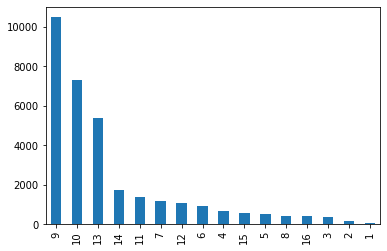

In [13]:
training['education-num'].value_counts().plot(kind="bar")

Com esse gráfico, é possível perceber que o valor mais frequente é o 9 (que corresponderia a HS-grad), com um pouco mais de 10000 ocorrências. Dado isso, podemos concluir que as duas colunas são redundantes.

Naturalmente, é de se esperar que um nível maior de educação resulte numa maior probabilidade de se ter uma renda alta. Vamos olhar a quantidade relativa de pessoas que ganham acima de 50k por nível educacional:

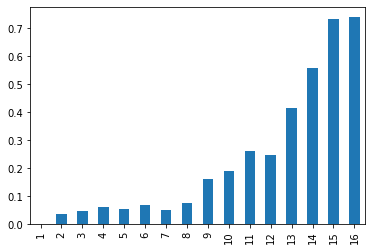

In [14]:
(training.loc[training['income']=='>50K']['education-num'].value_counts()/training['education-num'].value_counts()).plot(kind='bar')

De fato, **quanto maior o nível educacional, maior a proporção de pessoas que ganham bem**!

### 3.4. marital-status

Uma *feature* categórica indicando o estado civil.

In [15]:
training['marital-status'].unique()

array(['Divorced', 'Married-civ-spouse', 'Never-married', 'Widowed',
       'Married-AF-spouse', 'Married-spouse-absent', 'Separated'],
      dtype=object)

In [16]:
training['marital-status'].describe()

count                  32560
unique                     7
top       Married-civ-spouse
freq                   14976
Name: marital-status, dtype: object

Ou seja, há sete categorias diferentes, das quais "casado com um civil" é a mais frequente. Vejamos sua distribuição mais a fundo:

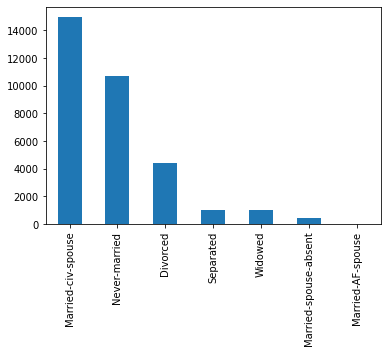

In [17]:
training['marital-status'].value_counts().plot(kind="bar")

Vamos investigar se a renda pode ter alguma relação com o estado civil:

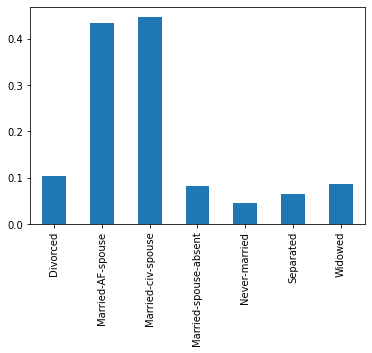

In [18]:
(training.loc[training['income']=='>50K']['marital-status'].value_counts()/training['marital-status'].value_counts()).plot(kind='bar')

De fato, a **proporção de pessoas de alta renda é mais alta entre os casados**. Pensando pelo senso comum, se as duas pessoas trabalham, as chances de se ter uma renda mais alta é maior. Ressalva-se, porém, que a classe de casamento com membro das forças armadas possui apenas 23 exemplos:

In [29]:
training.loc[training['marital-status']=='Married-AF-spouse'].shape

(23, 15)

### 3.5. occupation

Refere-se á profissão da pessoa.

In [21]:
training['occupation'].describe()

count              30717
unique                14
top       Prof-specialty
freq                4140
Name: occupation, dtype: object

In [22]:
training['occupation'].unique()

array(['Exec-managerial', 'Transport-moving', 'Machine-op-inspct',
       'Adm-clerical', 'Other-service', 'Sales', 'Handlers-cleaners',
       'Craft-repair', 'Tech-support', 'Prof-specialty', nan,
       'Priv-house-serv', 'Farming-fishing', 'Protective-serv',
       'Armed-Forces'], dtype=object)

Existem então 14 ocupações diferentes, dentre as quais a mais frequente é "prof-specialty". Vamos ver como é a distribuição desse atributo.

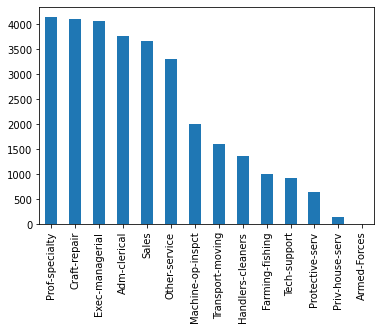

In [24]:
training['occupation'].value_counts().plot(kind="bar")

Ainda que um pouco mais homogênea do que as *features* anteriores, ainda há categorias com muitos poucos representantes. De qualquer forma, vamos olhar a porcentagem de alta renda em cada classe:

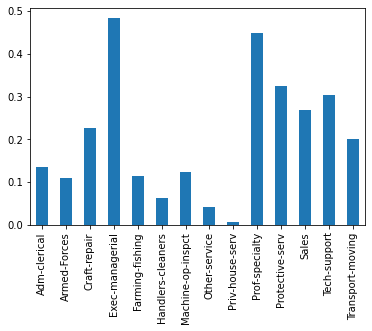

In [30]:
(training.loc[training['income']=='>50K']['occupation'].value_counts()/training['occupation'].value_counts()).plot(kind='bar')

Percebe-se que as classes que possuem maior quantidade de pessoas com alta renda são "Exec-managerial" e "Prof-specialty". De certa forma, são profissões que necessitam de maior grau de especialização.

### 3.6. race

In [31]:
training['race'].describe()

count     32560
unique        5
top       White
freq      27815
Name: race, dtype: object

In [32]:
training['race'].unique()

array(['White', 'Black', 'Asian-Pac-Islander', 'Amer-Indian-Eskimo',
       'Other'], dtype=object)

Das cinco diferentes raças, a grande maioria é a de brancos. Vamos conferir a distribuição:

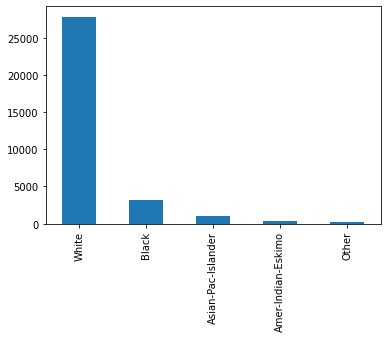

In [34]:
training['race'].value_counts().plot(kind="bar")

E a relação com a renda:

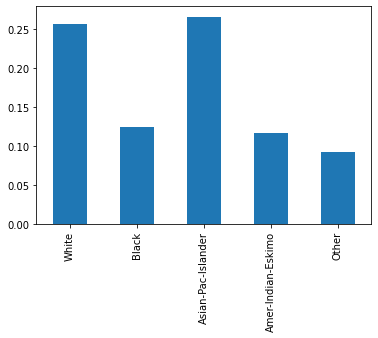

In [36]:
(training.loc[training['income']=='>50K']['race'].value_counts()/training['race'].value_counts()).plot(kind='bar')

Aqui fiquei surpredo com o maior porcentagem pertencendo à classe "Asian-Pacific-Islander", ainda que seguida de perto da classe "white". De quealeur forma, é preciso lembrar da quantidade muito menor de exemplos de asiáticos do que de brancos no dataset. Depois dessas duas raças, há um *gap* considerável com as outras. Aparentemente, **há uma certa desigualdade racial**.

### 3.7. sex

O sexo dos indivíduos.

In [37]:
training['sex'].describe()

count     32560
unique        2
top        Male
freq      21789
Name: sex, dtype: object

Aqui foram utilizados apenas "male" e "female".

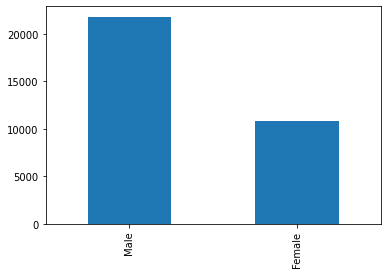

In [38]:
training['sex'].value_counts().plot(kind="bar")

Nesse censo, há uma maior representatividade do gênero masculino. Ainda assim, vamos investigar a relação do sexo com a renda:

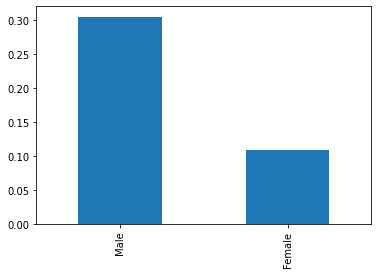

In [40]:
(training.loc[training['income']=='>50K']['sex'].value_counts()/training['sex'].value_counts()).plot(kind='bar')

A população masculina possui uma porcentagem muito maior de renda alta. Isso indica que há **desigualdade de gênero**

### 3.8. capital-gain e capital-loss

Indicam, respectivamente, o ganho ou a perda com a venda de um ativo.

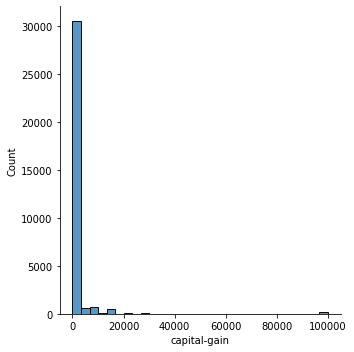

In [46]:
sns.displot(training['capital-gain'], bins=30)

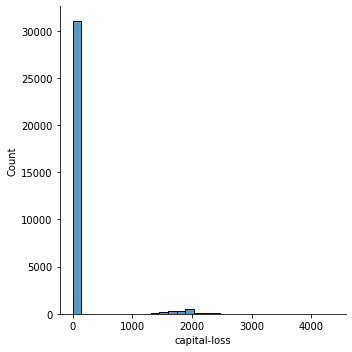

In [47]:
sns.displot(training['capital-loss'], bins=30)

Ambas as duas *features* são muito esparsas. Ainda assim, por senso comum, pode-se imaginar que pessoas que obtiveram ganhos tendem a ter renda alta, e, os que tiveram perdas, tendem a ter renda menor. Para termos alguma ideia, vamos comparar a porcentagem de pessoas com renda alta das que tiveram ganhos, perdas, ou nenhum.

In [67]:
# Porcentagem de com ganhos
(training.loc[training['capital-gain'] > 0]).loc[training['income'] == '>50K'].shape[0]/(training.loc[training['capital-gain'] > 0]).shape[0]

0.6185909258576171

In [68]:
# Porcentagem sem nada
(training.loc[training['capital-gain'] == 0]).loc[training['income'] == '>50K'].shape[0]/(training.loc[training['capital-gain'] == 0]).shape[0]

0.20650608060571543

In [69]:
# Porcentagem com perdas
(training.loc[training['capital-loss'] > 0]).loc[training['income'] == '>50K'].shape[0]/(training.loc[training['capital-loss'] > 0]).shape[0]

0.5088874259381172

Surpreendentemente, a classe com perdas continua com maior proporção de pessoas com renda alta do que a população sem perdas ou ganhos!

Podemos inferir, então, que, no geral, **pessoas que fazem investimentos tendem a ter maior renda - mesmo quando possuem prejuízos**

### 3.9. hours-per-week

A quantidade de horas trabalhadas por semana.

In [70]:
training['hours-per-week'].describe()

count    32560.000000
mean        40.437469
std         12.347618
min          1.000000
25%         40.000000
50%         40.000000
75%         45.000000
max         99.000000
Name: hours-per-week, dtype: float64

A maioria das pessoas trabalha próximo de 40 horas por semana. No entanto, o maior valor registrado é de 99 horas, que parece ser um *outlier*. Vamos ver a distribuição dessa *feature*:

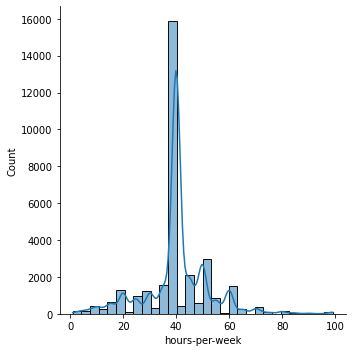

In [75]:
sns.displot(training['hours-per-week'], bins=30, kde=True)

Precisamos ver também se a quantidade de horas trabalhadas influencia na renda da pessoa. Para isso, vamos dividir a distribuição em dois gráficos - um com as pessoas que ganham pouco, e outra, com as pessoas que ganham muito:

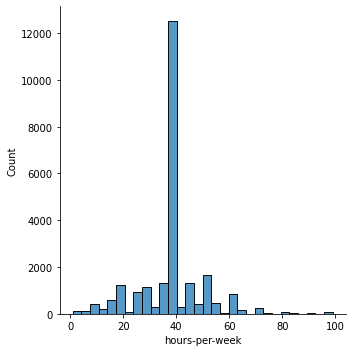

In [85]:
sns.displot(training.loc[training['income']=='<=50K']['hours-per-week'], bins=30)

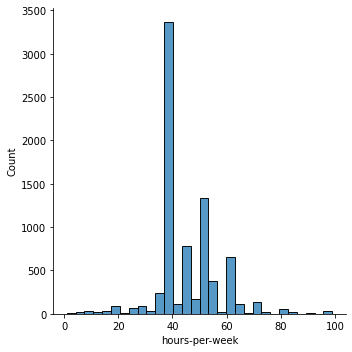

In [86]:
sns.displot(training.loc[training['income']=='>50K']['hours-per-week'], bins=30)